In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import csv
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import os
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config)

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RNN, GRU, SimpleRNN, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.preprocessing import MinMaxScaler
os.environ['CUDA_VISIBLE_DEVICES']=''
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [107]:
data = pd.read_csv('lstm_data.csv', header=None, names=['datetime', 'load'], index_col=[0], parse_dates=[0], infer_datetime_format=True)
df = pd.DataFrame(columns=['time'] + list(map(str, range(int(data.shape[0] / 288)))))
for idx, time in enumerate(sorted(set(data.index.time))):
    df.loc[idx] = [time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)
df.index = df['time']
df = df.drop('time', 1)
dt_df = df.diff(1, axis=1)
dt_df = dt_df.dropna(axis=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(dt_df.values.reshape(-1, 1))
dt_df = scaler.transform(dt_df)  # dt_df is now a numpy array
split_idx = int(len(dt_df) * 0.8)
train, val = dt_df[:split_idx, :], dt_df[split_idx:, :]

In [108]:
def prepare_data(data, nlags):
    '''prepares data for LSTM model, x=last nlags values, y=(nlags+1)'th value'''
    data_x, data_y = [], []
    for i in range(data.shape[0]):
        for j in range(0, data.shape[1]-nlags):
            data_x.append(data[i, j:j+nlags])
            data_y.append(data[i, j+nlags])
    data_x = np.array(data_x)
    data_y = np.array(data_y).reshape(-1, 1)
    return data_x, data_y

In [159]:
nlags = 10
train_x, train_y = prepare_data(train, nlags)
val_x, val_y = prepare_data(val, nlags)
train_x = train_x.reshape(train_x.shape[0], 1, nlags)
val_x = val_x.reshape(val_x.shape[0], 1, nlags)
df_last_nlags_plus_one = df.loc[:, df.columns[-nlags-1:]]  # slice last nlags+1 days from df, will be used in prediction of yesterday's data
dt_df_last_nlags = df_last_nlags_plus_one.diff(1, axis=1).dropna(axis=1)  #taking last 21 days, differencing and dropping the nan value
dt_df_last_nlags = scaler.transform(dt_df_last_nlags)  # df is now a numpy array
X = dt_df_last_nlags.reshape(dt_df_last_nlags.shape[0], 1, nlags)  # nlags=20
load = np.load('25nov.npy')

#### Training

In [161]:
del model
batch_size = 1
model = Sequential()
model.add(SimpleRNN(1, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2])))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [162]:
history = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), shuffle=True, callbacks=[es])


Train on 11270 samples, validate on 2842 samples
Epoch 1/20
11270/11270 [==============================] - 33s 3ms/step - loss: 0.0383 - val_loss: 0.0200
Epoch 2/20
11270/11270 [==============================] - 31s 3ms/step - loss: 0.0268 - val_loss: 0.0199
Epoch 3/20
11270/11270 [==============================] - 31s 3ms/step - loss: 0.0266 - val_loss: 0.0203
Epoch 4/20
11270/11270 [==============================] - 31s 3ms/step - loss: 0.0265 - val_loss: 0.0204
Epoch 5/20
11270/11270 [==============================] - 32s 3ms/step - loss: 0.0263 - val_loss: 0.0200


In [153]:
# fit network
early_stopping_counter = 0
last_loss = np.inf
for i in range(20):
    history = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y), shuffle=False)
    model.reset_states()
    val_loss = history.history['val_loss'][0]
    if val_loss > last_loss:
        early_stopping_counter += 1
    else:    
        early_stopping_counter = 0
    last_loss = val_loss
    if early_stopping_counter == 3:
#         break
        pass

Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==============================] - 27s 3ms/step - loss: 0.0315 - val_loss: 0.0190
Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==============================] - 27s 3ms/step - loss: 0.0311 - val_loss: 0.0191
Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==============================] - 28s 3ms/step - loss: 0.0307 - val_loss: 0.0190
Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==============================] - 27s 3ms/step - loss: 0.0303 - val_loss: 0.0191
Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==============================] - 27s 3ms/step - loss: 0.0301 - val_loss: 0.0189
Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==============================] - 25s 2ms/step - loss: 0.0298 - val_loss: 0.0185
Train on 10120 samples, validate on 2552 samples
Epoch 1/1
10120/10120 [==========

#### Prediction

In [163]:
val_y_pred = model.predict(val_x, batch_size=batch_size, verbose=1)
inverted_val_y = scaler.inverse_transform(val_y)
inverted_val_y_pred = scaler.inverse_transform(val_y_pred)
Y = model.predict(X, batch_size=batch_size)  # predict for today's values
inv_Y = scaler.inverse_transform(Y)  # invert to detrended values' scale
rescaled_Y = [x+y for x, y in zip(inv_Y[:, 0], df.iloc[:, -1])]  # last day's values added to inv_Y to get it to original scale


2842/2842 [==============================] - 3s 1ms/step


In [164]:
val_RMSE = np.sqrt(np.sum(np.square(np.array(inverted_val_y_pred) - np.array(inverted_val_y))) / len(inverted_val_y)) 
RMSE = np.sqrt(np.sum(np.square(np.array(rescaled_Y) - load)) / len(load)) 
print(val_RMSE, RMSE)

166.6308253179372 190.08200151118467


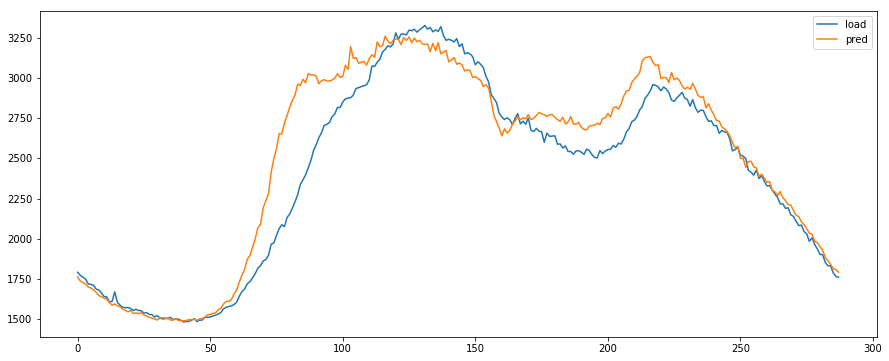

In [165]:
plt.plot(load)
plt.plot(rescaled_Y)
plt.legend(['load', 'pred'])

In [40]:
# !jupyter nbconvert --to script LSTM-v2.ipynb

[NbConvertApp] Converting notebook LSTM-v2.ipynb to script
[NbConvertApp] Writing 9421 bytes to LSTM-v2.py


In [41]:
# ## get today's load

# def get_load_data(date):
#     load=[]
#     url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
#     print('Scraping ' + date, end=' ')
#     resp = requests.get(url + date) # send a get request to the url, get response
#     soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
#     table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
#     trs = table.findAll('tr') # extract all rows of the table
#     if len(trs[1:])==288: # no need to create csv file, if there's no data
#         with open('monthdata.csv', 'a') as f:  #'a' makes sure the values are appended at the end of the already existing file
            
#             for tr in trs[1:]:
#                 time, delhi = tr.findChildren('font')[:2]
#                 load.append(delhi.text)
#     if len(trs[1:]) != 288:
#         print('Some of the load values are missing..')
#     else:
#         print('Done')
#     return load

# yesterday = datetime.today() - timedelta(1)
# yesterday = yesterday.strftime('%d/%m/%Y')
# load = get_load_data(yesterday)
# load = [float(x) for x in load]
# np.save('25nov.npy', load)